# Using NP4VTT: Logistic regression

In this notebook, we show how to use a logistic regression model to estimate the distribution of the Value of Travel Time (VTT) from the Norway data.

## Step 1: Load modules and data, and create arrays

We first import the NP4VTT modules for creating the arrays, the logistic regression model, and Pandas to load the dataset:

In [1]:
import pandas as pd

from py_np4vtt.data_format import StudyVar
from py_np4vtt.model_logistic import ModelLogistic, ConfigLogistic
from py_np4vtt.data_import import make_modelarrays, compute_descriptives


Now we read the CSV file:

In [2]:
df = pd.read_table('../data/Norway09_data_v5.txt')
df.head()

,RespID,Mode,TravTime,BaseCost,Gender,AgeClass,IncClass,TravTimeClass,Purpose,CardID,...,TimeL,TimeR,Chosen,Quadrant2,Purpose2,Mode2,Income2,ExclGroup,Exclude_CDF,CS
0,88,1,25,27,1,3,5,1,1,1,...,32,25,1,4,1,1,3,4,1,1
1,88,1,25,27,1,3,5,1,1,2,...,25,28,2,2,1,1,3,4,1,2
2,88,1,25,27,1,3,5,1,1,3,...,29,25,1,4,1,1,3,4,1,3
3,88,1,25,27,1,3,5,1,1,4,...,32,25,1,2,1,1,3,4,1,4
4,88,1,25,27,1,3,5,1,1,5,...,29,32,2,2,1,1,3,4,1,5


The dataset contains 22 variables. Each row is a binary choice task. We will use:

* `RespID`: ID of each respondent.
* `Chosen`: Chosen alternative.
* `CostL` and `CostR`: Travel cost of alternatives 1 and 2, respectively.
* `TimeL` and `TimeR`: Travel time of alternatives 1 and 2, respectively.

NP4VTT detects automatically the _slow-cheap_ and _fast-expensive_ alternative, for each choice situation. If NP4VTT finds violations to those two options (e.g., a fast-cheap) alternative, it will raise an error message.

Now we create a dictionary to map the required variables for NP4VTT with the variables of the dataset:

In [3]:
columnarrays = {
    StudyVar.Id: 'RespID',
    StudyVar.ChosenAlt: 'Chosen',
    StudyVar.Cost1: 'CostL',
    StudyVar.Cost2: 'CostR',
    StudyVar.Time1: 'TimeL',
    StudyVar.Time2: 'TimeR',
}

And we create the required arrays:

In [4]:
model_arrays = make_modelarrays(df, columnarrays)

The function `make_modelarrays` creates six elements used by NP4VTT to estimate/train a model:

* `BVTT`: Contains the Boundary VTT per choice situation, computed from costs and time.
* `Choice`: A matrix of dummy variables that are equal to one if the respondent choose the fast-expensive alternative on each choice situation.
* `Accepts`: Number of times a respondent chose the fast-expensive alternative.
* `ID`: Unique identifier of each respondent.
* `NP`: Number of respondents in the dataset.
* `T`: Number of choice situations per respondent.

## Step 2: Compute descriptives

The function `compute_descriptives` provides a small overview of the dataset characteristics:

In [5]:
descriptives = compute_descriptives(model_arrays)
print(descriptives)

No. individuals: 5832
Sets per indiv.: 9

Number of non-traders:
Fast-exp. alt.: 144
Slow-cheap alt.: 808

BVTT statistics:
Mean chosen BVTT: 0.5370130170428368
Minimum of BVTT: 0.1
Maximum of BVTT: 17.03448275862069


## Step 3: Configure a logistic regression model

The logistic regression model requires the following parameters from the user:

* `mleIntercept`: The starting value of the intercept parameter
* `mleParameter`: The starting value of the VTT parameter.
* `mleScale`: The starting value of the scale parameter.

Additionally, the user can configure the following options:
* `mleMaxIterations:` Maximum iterations of the maximum likelihood estimation routine.
* `seed`: Random seed for the array creation in the logistic regression model.

The function `ConfigLogistic` takes the configuration parameters of the logistic regression and creates an object that is used by the optimisation routine:

In [6]:
config = ConfigLogistic(mleIntercept=1, mleParameter=0.1, mleScale=1, mleMaxIterations=10000, seed=12345)

Now, we create the logistic regression model object that contains the configuration parameters and the data arrays. Then, we initialise the arguments and the initial value of the likelihood function:

In [7]:
logistic = ModelLogistic(config, model_arrays)
initialArgs, initialVal = logistic.setupInitialArgs()

## Step 4: Estimate a logistic regression model

Once the logistic regression is initialised, the `run` method starts the optimisation process:

In [8]:
x, se, fval, exitflag, output = logistic.run(initialArgs)

The estimated model returns the following information:

* `x:` The estimated parameters for the intercept, the VTT parameter, and the scale.
* `se:` The standard error of the estimated parameters.
* `fval:` Value of the likelihood function in the optimum.
* `exitflag:` Exit flag of the optimisation routine.
* `output:` output message of the optimisation routine.

The following lines present the estimated results:

In [9]:
import numpy as np

# Create dataframe
results = pd.DataFrame(np.c_[x,se],columns=['Estimate','Std.Err'],index=['Scale','Intercept','Parameter'])

print('Estimation results:\n')
print('Initial log-likelihood: ' + str(round(initialVal,2)))
print('Final log-likelihood: ' + str(round(fval,2)))
print(output + '\n')
print('Estimates:')
print(results)

Estimation results:

Initial log-likelihood: -2832.57
Final log-likelihood: -2488.77
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH

Estimates:
           Estimate   Std.Err
Scale      0.982572  0.032059
Intercept  0.337889  0.050236
Parameter  0.312953  0.009674


The VTT for each respondent can be computed from the estimated parameters and the model arrays:

In [10]:
T = model_arrays.T
NP = model_arrays.NP
BVTT = model_arrays.BVTT
Choice = model_arrays.Choice

VTT = x[1] + x[2]*((T-1)/T)*np.sum(Choice*BVTT,1)

## Step 5: Do plots

We create two plots of the VTT distribution:
* Histogram
* Empirical CDF

We use matplotlib for this:

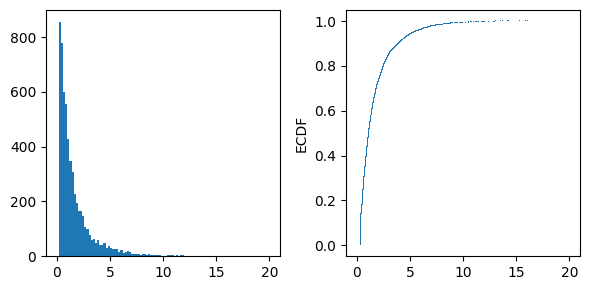

In [11]:
import matplotlib.pyplot as plt
from mlxtend.plotting import ecdf
fig, (ax1,ax2) = plt.subplots(1,2,sharex=True,figsize=(6,3), dpi=100)

# Histogram
ax1.hist(VTT,bins=100,range=(0,20))

# ECDF
ax2 = ecdf(VTT,ecdf_marker=',')

plt.tight_layout()